In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor

In [3]:
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [4]:
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler


def dataset_load(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    n = 99
    units_to_pad = n // 2
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    # train
    for key, values in train.items():
        for app in range(len(appliances)):
            df = pd.read_csv(
                f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[app]])
            df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
            startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
            endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

            if startDate > endDate:
                raise "Start Date must be smaller than Enddate."

            df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
            df.dropna(inplace=True)
            if app == 0:
                x = df[appliances[app]].values
            else:
                # print(app)
                x += df[appliances[app]].values
            if appliances[app] == "Refrigerator":
                y = df[appliances[app]].values
            # x = df["main"].values
            # y = df[appliances[app]].values
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_train.extend(x)
        y_train.extend(y)
        x_train_timestamp.extend(torch.tensor(timestamp_train))


    x_train = jnp.array(x_train)
    y_train = jnp.array(y_train).reshape(-1, 1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)


    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    x_test_timestamp_true =[]
    for key, values in test.items():
        for app in range(len(appliances)):
            df = pd.read_csv(
                f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[app]])
            df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
            startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
            endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

            if startDate > endDate:
                raise "Start Date must be smaller than Enddate."

            df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
            df.dropna(inplace=True)
            if app == 0:
                    x = df[appliances[app]].values
            else:
                print(app)
                x += df[appliances[app]].values
            if appliances[app] == "Refrigerator":
                y = df[appliances[app]].values
            # x = df["main"].values
            # y = df[appliances[0]].values
        x =  x + 100*np.ones(x.shape[0])
        timestamp_true = df["Timestamp"].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_test.extend(x)
        y_test.extend(y)
        x_test_timestamp_true.extend(timestamp_true)
        x_test_timestamp.extend(timestamp)

    x_test = jnp.array(x_test)
    y_test = jnp.array(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)
#     y_test = scaler_y.transform(y_test)

    x_train = jnp.array(x_train).reshape(x_train.shape[0], n, 1)
    y_train = jnp.array(y_train)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = jnp.array(x_test).reshape(x_test.shape[0], n, 1)
    y_test = jnp.array(y_test)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).to(torch.float64)

    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, x_test_timestamp_true, scaler_x, scaler_y, scaler_time


In [5]:
train ={1:{
                    'start_time': "2011-04-28" ,
                    'end_time': "2011-05-15"
                }, 3: {
                'start_time': "2011-04-19" ,
                'end_time': "2011-05-22"
            },
                
      
                }
test = {  2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                }

# 6: {
#                     'start_time': "2011-05-25" ,
#                     'end_time': "2011-06-13"
#                 }

# 5: {
#                     'start_time': "2011-04-22" ,
#                     'end_time': "2011-06-01"
#                 }
appliances = ["Microwave", "Refrigerator",  "Dish Washer"] #

In [6]:
x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, x_test_time_true, scaler_x, scaler_y, scaler_time = dataset_load(appliances, train, test)

1
2


In [20]:
# df = pd.DataFrame(x_test_time_true)
  
# # saving the dataframe
# df.to_csv('time_stamp.csv')

In [7]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((24918, 99, 1), (15656, 99, 1), (24918, 1), (15656, 1))

In [8]:
x_train = x_train.reshape(-1,99)
x_test = x_test.reshape(-1,99)

In [9]:
# plt.plot(x_train_timestamp, scaler_x.inverse_transform(x_train.reshape(-1,99)))
# plt.ylabel(f"Main Power Train")
# plt.xlabel(f"Timestamp Train")

In [10]:
x_train_full = jnp.concatenate((jnp.array(x_train), jnp.array(x_train_timestamp)), axis=1)
x_test_full = jnp.concatenate((jnp.array(x_test), jnp.array(x_test_timestamp)), axis=1)
# x_train_full = x_train
# x_test_full =x_test
x_train_full.shape, x_test_full.shape

((24918, 100), (15656, 100))

In [11]:
x = torch.tensor(np.array(x_train_full)).to(torch.float64)
y = torch.tensor(np.array(y_train)).reshape(-1,).to(torch.float64)
xt = torch.tensor(np.array(x_test_full)).to(torch.float64)
yt = torch.tensor(np.array(y_test)).reshape(-1,).to(torch.float64)

In [12]:
x.shape, xt.shape

(torch.Size([24918, 100]), torch.Size([15656, 100]))

restart: 0, epoch: 1, iter: 1, loss: 1.7119
restart: 0, epoch: 2, iter: 1, loss: 1.7009
restart: 0, epoch: 3, iter: 1, loss: 1.6890


/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


restart: 0, epoch: 4, iter: 1, loss: 1.6767
restart: 0, epoch: 5, iter: 1, loss: 1.6646
restart: 0, epoch: 6, iter: 1, loss: 1.6550
restart: 0, epoch: 7, iter: 1, loss: 1.6444
restart: 0, epoch: 8, iter: 1, loss: 1.6353
restart: 0, epoch: 9, iter: 1, loss: 1.6268
restart: 0, epoch: 10, iter: 1, loss: 1.6190
restart: 0, epoch: 11, iter: 1, loss: 1.6103
restart: 0, epoch: 12, iter: 1, loss: 1.6018
restart: 0, epoch: 13, iter: 1, loss: 1.5929
restart: 0, epoch: 14, iter: 1, loss: 1.5857
restart: 0, epoch: 15, iter: 1, loss: 1.5783
restart: 0, epoch: 16, iter: 1, loss: 1.5706
restart: 0, epoch: 17, iter: 1, loss: 1.5631
restart: 0, epoch: 18, iter: 1, loss: 1.5562
restart: 0, epoch: 19, iter: 1, loss: 1.5494
restart: 0, epoch: 20, iter: 1, loss: 1.5435
restart: 0, epoch: 21, iter: 1, loss: 1.5367
restart: 0, epoch: 22, iter: 1, loss: 1.5307
restart: 0, epoch: 23, iter: 1, loss: 1.5246
restart: 0, epoch: 24, iter: 1, loss: 1.5180
restart: 0, epoch: 25, iter: 1, loss: 1.5131
restart: 0, epoc

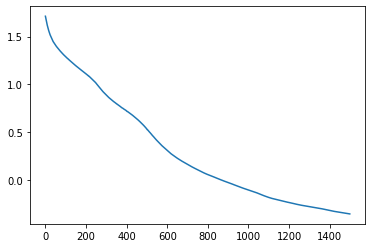

In [13]:
mae_arr =[]
rms_arr = []
y_pred_arr = []

batch = 512

# x_train = x_train[:4500]
# y_train = y_train[:4500]

# y_test_trans = torch.tensor(torch.tensor(scaler_x.transform(y_test.reshape(-1,1))).reshape(-1,)).contiguous().to(torch.float64)
for i in range(1):


  kernel1 = ScaleKernel(MaternKernel(nu=2.5,ard_num_dims=100)) #nu=2.5,
  kernel2 = ScaleKernel(PeriodicKernel( ard_num_dims=1, active_dims=(99)))
  kernel3 = ScaleKernel(MaternKernel(nu=0.5, ard_num_dims=1, active_dims=(99)))
  # kernel4 = ScaleKernel(PeriodicKernel(ard_num_dims=2, active_dims=(0)))
  # kernel5 = ScaleKernel(CosineKernel(ard_num_dims=2, active_dims=(1)))

  kernel4 =  kernel2 + kernel3
  kernel = kernel1 + kernel4
  # induce_points = 512
  theta = { 
      'base_covar_module.kernels.1.base_kernel.period_length': torch.tensor(0.01),}
  inducing_points =  x[np.arange(0,x.shape[0],30)] 
  #x[torch.randperm(x.shape[0])[: batch]].to("cuda")
  
  model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
                       inducing_points).to("cuda")
  # model.mll.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-2))
  # for param in model.parameters():
  #   # print(param)
  #   torch.nn.init.normal_(param, 0, 1)
  # theta1 = {'likelihood.noise_covar.noise': torch.tensor(3),
  #       'covar_module.base_kernel.lengthscale': torch.tensor(0.1),
  #       'covar_module.outputscale': torch.tensor(5),}
  loss = model.fit(lr=1e-2, n_epochs=1500,verbose=1,thetas=theta,
          random_state=0)
#   loss_arr.append(loss)
  # print(loss)
  plt.plot(np.asarray(loss[0]))
  # plt.plot(np.asarray(test_loss[0]))


  

In [55]:
model_name = "Point_to_point_main_power_seq_and_time_exp2.pt"
torch.save(model.state_dict(), os.path.join(
  "Neurips/models", model_name))

In [21]:
# kernel1 = ScaleKernel(RBFKernel(ard_num_dims=1, active_dims=(0))) #nu=2.5,
# # kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1, active_dims=(1)))
# # kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=1, active_dims=(1)))
# # kernel4 = ScaleKernel(PeriodicKernel(ard_num_dims=2, active_dims=(0)))
# # kernel5 = ScaleKernel(CosineKernel(ard_num_dims=2, active_dims=(1)))

# kernel = kernel1# + kernel2*kernel3
# # induce_points = 512
# inducing_points =  x_train[np.arange(0,x_train.shape[0],20)] 
# #x_train_full[torch.randperm(x_train_full.shape[0])[: batch]].to("cuda")

# model = SGPRegressor(x_train.to("cuda"), y_train.to("cuda"), kernel,
#                       inducing_points).to("cuda")

# model_name = "Refrigerator_trial_atrificial_main_only_main_fold3.pt"
# model.load_state_dict(torch.load(
#     os.path.join("models/", model_name)))

In [14]:
y_pred_arr =[]
pred_dist = model.predict(xt.to("cuda"))

y_pred_arr.append(pred_dist.loc)

In [15]:
y_pred_arr1 = []
for i in range(len(y_pred_arr)):
  y_pred_arr1.append(np.array(y_pred_arr[i].cpu()))

In [16]:
y_mean = np.mean(y_pred_arr1, axis =0)
# y_sigma = np.std(y_pred_arr1, axis=0)

y_mean.shape#, y_sigma.shape

y_mean = scaler_y.inverse_transform(y_mean.reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(y_test.shape, y_mean.shape)

y_mean = np.clip(y_mean,0,y_mean.max(),out=y_mean)

(15656, 1) (15656,)


In [17]:
mae = np.mean(np.abs(np.array(yt) - y_mean))
rms = errors.rmse(jnp.array(yt), y_mean)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  97.30459009837553
RMSE:  100.50382


In [14]:
try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled

os.environ["LATEXIFY"] = "1"
os.environ["FIG_DIR"] = "Neurips/FinalPlots/"

In [18]:
# x_lin1 = jnp.sort(x_train_full, axis=1)
# x_lin1.shape
x_lin_max = 3000
x_lin = np.linspace(0,x_lin_max,15656).reshape(-1,1) # + 100*np.ones(15656).reshape(-1,1)

x_lin1 = np.array(x_lin).reshape(-1,1)
for i in range(98):
  x_lin1 = np.concatenate((x_lin1, x_lin), axis=1)

test_range = []
for i in range(15656):
  test_range.append(jnp.max(x_lin1[i], axis=0)-jnp.min(x_lin1[i], axis=0))
test_range = np.array(test_range)
x_lin1.shape
x_lin_scale = scaler_x.transform(x_lin1)
x_time = np.linspace(scaler_time.inverse_transform(x_test_timestamp).min(), scaler_time.inverse_transform(x_test_timestamp).max(), 15656)
# x_lin_scale = scaler_x.transform(x_lin.reshape(-1,1)).flatten() 
# x_new =torch.tensor(x_lin_scale).reshape(-1,1).to(torch.float32)
x_time_scale =  scaler_time.transform(x_time.reshape(-1,1)).flatten() 
# x_new = torch.tensor(np.array(x_lin_scale)).to(torch.float32)
x_new = torch.cat((torch.tensor(x_lin_scale).to(torch.float32), torch.tensor(x_test_timestamp).reshape(-1,1)),dim=1 ).to(torch.float32)
x_new.shape, x_new.dtype

/tmp/ipykernel_3202965/1528941294.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_new = torch.cat((torch.tensor(x_lin_scale).to(torch.float32), torch.tensor(x_test_timestamp).reshape(-1,1)),dim=1 ).to(torch.float32)


(torch.Size([15656, 100]), torch.float32)

In [19]:
pred_dist = model.predict(x_new.to("cuda"))
y_mean = pred_dist.loc 
y_mean = scaler_y.inverse_transform(y_mean.cpu().reshape(-1,1))

Text(0, 0.5, 'Train Appliance Power')

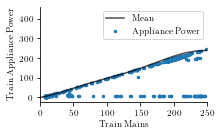

In [20]:
plt.figure()
latexify(width_scale_factor=2, fig_height=1.75)

start = 0
idx = 5000
plt.plot(x_lin1[:,49], y_mean, 'k', label="Mean", alpha=0.7)
plt.scatter( scaler_x.inverse_transform(x_train_full[:,0:99])[:,49][start:start+idx], scaler_y.inverse_transform(y_train.reshape(-1,1))[start:start+idx], s = 6, label="Appliance Power")
plt.xlim(0,250)
sns.despine()
plt.legend()
plt.xlabel("Train Mains")
plt.ylabel("Train Appliance Power")
# plt.show()
# savefig("Main_seq_time_vs_app_mean")

## Actual

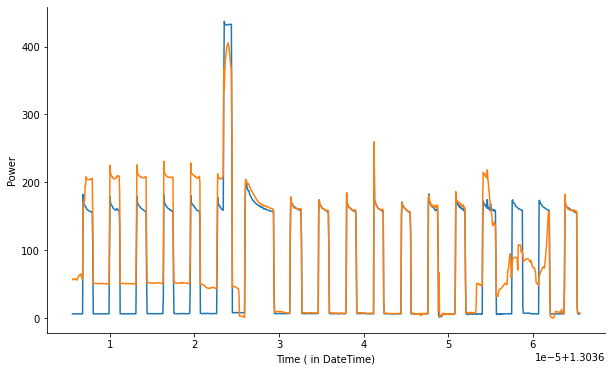

In [30]:
idx = 1000
start = 4000
plt.figure(figsize=(10,6))
time_plot = scaler_time.inverse_transform(x_test_timestamp.reshape(-1,1))
# latexify(width_scale_factor=1.5, fig_height=2)
# plt.plot(time_plot[start : start + idx], scaler_x.inverse_transform(xt)[:,49][start : start + idx], label = "Main Power")
plt.plot(time_plot[start : start + idx], y_test[start : start + idx], label = "Ground Truth")
plt.plot(time_plot[start : start + idx], y_mean[start : start + idx], label = "Prediction")
# plt.legend(frameon=False, ncol=2)
plt.xlabel("Time ( in DateTime)")
plt.ylabel("Power")
sns.despine()
plt.show()
# savefig("Point_to_point_main_power_add100_sudden_pred")

In [49]:
for name, params in model.named_parameters():
  print(name, params)

mll.likelihood.noise_covar.raw_noise Parameter containing:
tensor([-4.0766], device='cuda:0', requires_grad=True)
mll.model.mean_module.constant Parameter containing:
tensor([0.8700], device='cuda:0', requires_grad=True)
mll.model.base_covar_module.raw_outputscale Parameter containing:
tensor(-2.5899, device='cuda:0', requires_grad=True)
mll.model.base_covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[10.4251, 10.8671, 11.2113, 11.2482, 11.2213, 11.3358, 11.2443, 11.4213,
         11.6552, 11.6334, 11.7098, 11.4688, 11.5728, 11.4793, 11.4923, 11.6508,
         11.8268, 11.9869, 11.7231, 11.9634, 11.8792, 11.9776, 12.0374, 12.1292,
         12.1015, 12.1548, 12.1259, 12.0086, 12.0525, 12.0732, 12.0210, 11.6221,
         11.8350, 11.9144, 11.9817, 11.5319, 11.4422, 11.4816, 11.4924, 11.5062,
         11.4141, 11.4433, 11.4957, 11.4067, 11.4078, 11.1971, 11.1387,  9.9038,
          8.8081, -0.1963,  6.7484, 11.8245, 12.2235, 12.3450, 12.8252, 12.1872,
         12.199

(99,)


Text(0, 0.5, 'Learned Lengthscale Values')

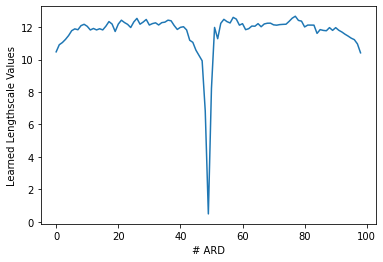

In [17]:
ar = np.arange(0,99,1)
print(ar.shape)
plt.plot(ar,model.mll.model.base_covar_module.base_kernel.lengthscale.cpu().detach().numpy().reshape(-1,))
plt.xlabel("# ARD")
plt.ylabel("Learned Lengthscale Values")

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

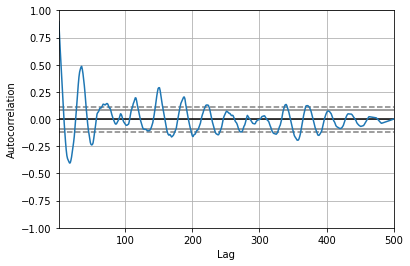

In [21]:
pd.plotting.autocorrelation_plot(pd.Series(y[:500].reshape(-1,)))

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

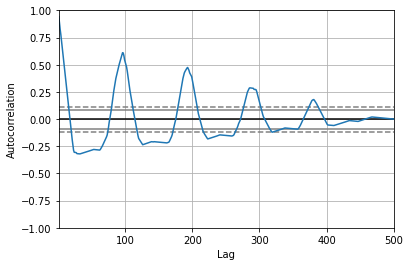

In [22]:
pd.plotting.autocorrelation_plot(pd.Series(yt[:500].reshape(-1,)))

## Decomposition

In [33]:
model1 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel1,
                      inducing_points).to("cuda")

In [35]:
pred_dist1 = model1.predict(xt[:4000].to("cuda"))
# print("Done ", i)

y_mean1 = pred_dist1.loc

In [36]:
y_pred_arr =[]

y_pred_arr.append(pred_dist1.loc)

In [37]:
y_mean1.shape

torch.Size([4000])

In [38]:
y_pred_arr1 = []
for i in range(len(y_pred_arr)):
  y_pred_arr1.append(np.array(y_pred_arr[i].cpu()))

In [39]:
y_mean1 = np.mean(y_pred_arr1, axis =0)
# y_sigma = np.std(y_pred_arr1, axis=0)

y_mean1.shape#, y_sigma.shape

y_mean1 = scaler_y.inverse_transform(y_mean1.reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(y_test.shape, y_mean1.shape)

y_mean1 = np.clip(y_mean1,0,y_mean1.max(),out=y_mean1)

(15656, 1) (4000,)


In [40]:
mae = np.mean(np.abs(np.array(y_test[:4000]) - y_mean1))
rms = errors.rmse(jnp.array(y_test[:4000]), y_mean1)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  80.53333534607472
RMSE:  112.83561


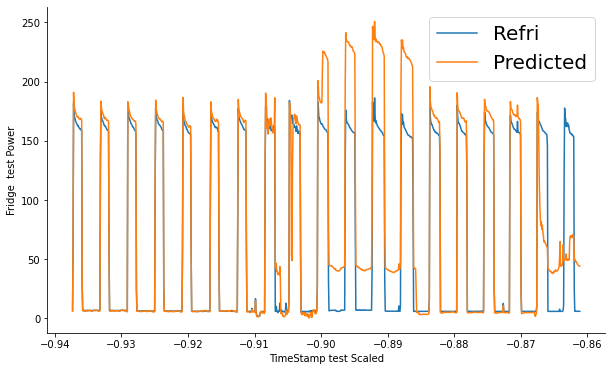

In [44]:
idx = 1000
start =3000
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp[start:start+idx], yt.cpu()[start:start+idx], label = "Refri")
plt.plot(x_test_timestamp[start:start+idx], y_mean1[start:start+idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()

In [21]:
model2 = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel4,
                      inducing_points).to("cuda")

In [22]:
pred_dist2 = model2.predict(xt[:4000].to("cuda"))
# print("Done ", i)

y_mean2 = pred_dist2.loc

In [23]:
y_pred_arr =[]

y_pred_arr.append(pred_dist2.loc)

In [24]:
y_pred_arr1 = []
for i in range(len(y_pred_arr)):
  y_pred_arr1.append(np.array(y_pred_arr[i].cpu()))

In [25]:
y_mean2 = np.mean(y_pred_arr1, axis =0)
# y_sigma = np.std(y_pred_arr2, axis=0)

y_mean2.shape#, y_sigma.shape

y_mean2 = scaler_y.inverse_transform(y_mean2.reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(y_test.shape, y_mean2.shape)

y_mean2 = np.clip(y_mean2,0,y_mean2.max(),out=y_mean2)

(15656, 1) (4000,)


In [26]:
mae = np.mean(np.abs(np.array(y_test[:4000]) - y_mean2))
rms = errors.rmse(jnp.array(y_test[:4000]), y_mean2)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  67.70062175456236
RMSE:  81.71757


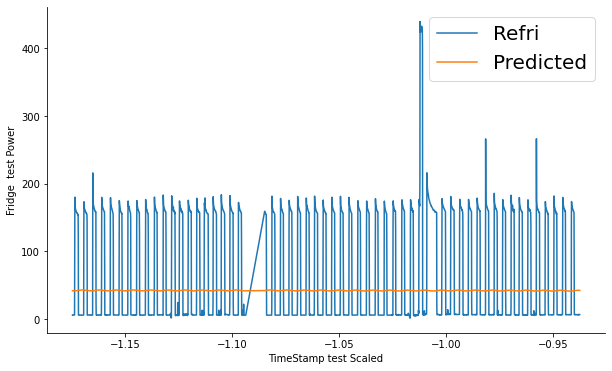

In [27]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp[:idx], yt.cpu()[:idx], label = "Refri")
plt.plot(x_test_timestamp[:idx], y_mean2[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()